### Slide 1: VAE for EEG

In [1]:
import scipy.signal
import numpy as np
import sys
import matplotlib.pyplot as plt
import random
import torch
sys.path.append("../")
sys.path.append("../data")
sys.path.append("../visualize")
sys.path.append("../models")
sys.path.append("../artifacts/")
from load_EEGs_1c import EEGDataset1c
from load_EEGs_mc import EEGDatasetMc
import stacklineplot
from constants import *
from models import *
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = [8, 4]

Reconstructions

In [25]:
plt.rcParams['figure.figsize'] = [18, 10]
samples = np.load("1600580967-sample-eval-350.npy")

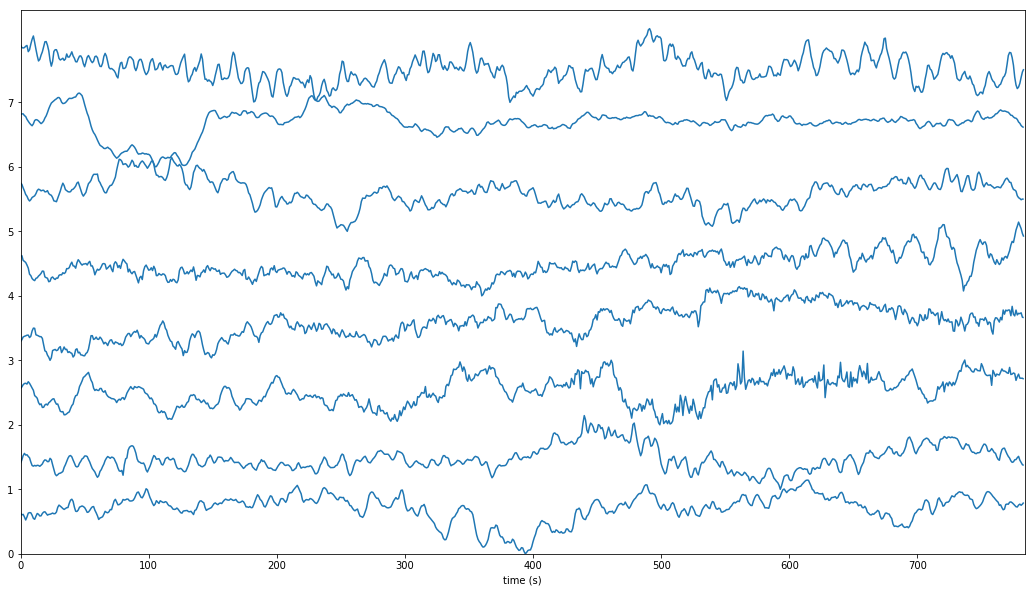

In [26]:
stacklineplot.stackplot(samples[:8], yscale=.8)

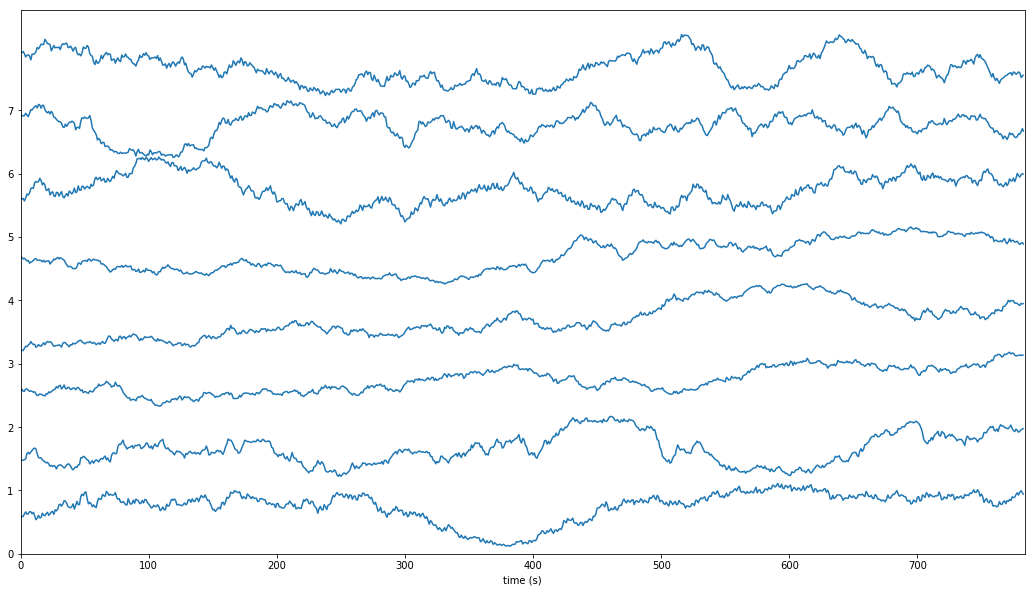

In [4]:
stacklineplot.stackplot(samples[16:16+8], yscale=.8)

### Slide 2: Breakdown of PSD

In [177]:
def get_avg_sampling_psd(model_filename):
    model = torch.load(model_filename)
    model.eval()
    samples = model.sample(64*2)
    fs = 200
    f, Pxx_den = scipy.signal.periodogram(samples, fs)
    
    Pxx_den = np.sum(Pxx_den, axis=0) / np.sum(Pxx_den) #Pxx_den.shape[0]
    plt.semilogy(f, Pxx_den)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
#     plt.show()
    
def get_avg_dataset_psd(dataset, plot=False):
    fs = 200
    Pxx_den_list = []
    for i, sample in enumerate(dataset):
        if i >= len(dataset):
            break
        f, Pxx_den = scipy.signal.periodogram(sample, fs)
        Pxx_den_list.append(Pxx_den)
    Pxx_den = np.asarray(Pxx_den_list).squeeze()
    Pxx_den = np.sum(Pxx_den, axis=0) / np.sum(Pxx_den) #Pxx_den.shape[0]
    plt.semilogy(f, Pxx_den)
    plt.xlabel('frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    if plot:
        plt.show()

/mnt/home2/dlongo/.conda/envs/mne-2/lib/python3.6/site-packages/torch/serialization.py:435: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


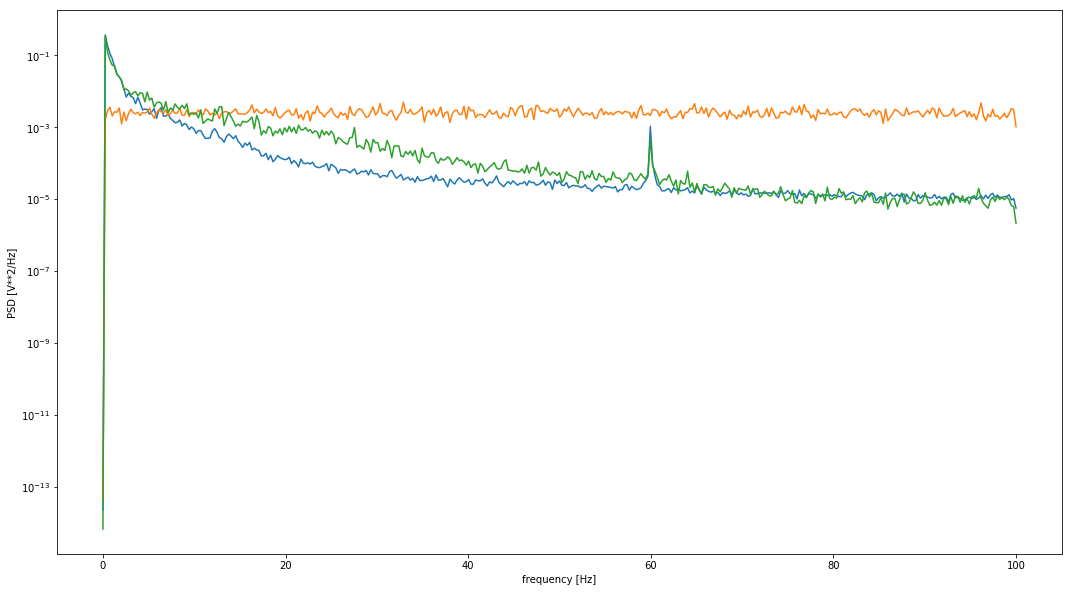

In [18]:
model_filename="/mnt/home2/dlongo/neuralFill/reconstruction/saved_runs/1600566403/model.pt" 
forward_model_filename = "/mnt/home2/dlongo/neuralFill/reconstruction/saved_runs/1600567998/model.pt"
get_avg_sampling_psd(model_filename=model_filename)
get_avg_sampling_psd(model_filename=forward_model_filename)

plt.rcParams['figure.figsize'] = [18, 10]
dataset = EEGDatasetMc(DEV_NORMAL_FILES_CSV, length=784, normalize=True, select_channels=[0])
get_avg_dataset_psd(dataset)

<h4>Key</h4>
<div>
<p style="color:rgb(255,119,19)">VAE trained on forward model</p>
<p style="color:blue">VAE</p>
<p style="color:green">Dataset</p>
</div>

The biggest discrepancy in frequency between the VAE samples and dataset is between the 20 to 40hz range. This is consistant with the plots which show the VAE reconstructing low frequency elements and "faking' high frequency elements. Mid/highish elements lost.

### Slide 3: The Forward Model

In [19]:
from forward_model_dataloader_1c import ForwardModelDataset1c
fwd_model_dataset = ForwardModelDataset1c(64, length=748)

    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
Reading forward solution from /mnt/home2/dlongo/eegML/forward_model/sample_forward_model...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]


../data/forward_model_dataloader_1c.py:64: RuntimeWarning: This filename (/mnt/home2/dlongo/eegML/forward_model/sample_forward_model) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution("/mnt/home2/dlongo/eegML/forward_model/sample_forward_model")


Projecting source estimate to sensor space...
[done]
Projecting source estimate to sensor space...
[done]
Projecting source estimate to sensor space...
[done]


In [20]:
fwd_sample = np.asarray([fwd_model_dataset[i].numpy() for i in range(16)]).squeeze()

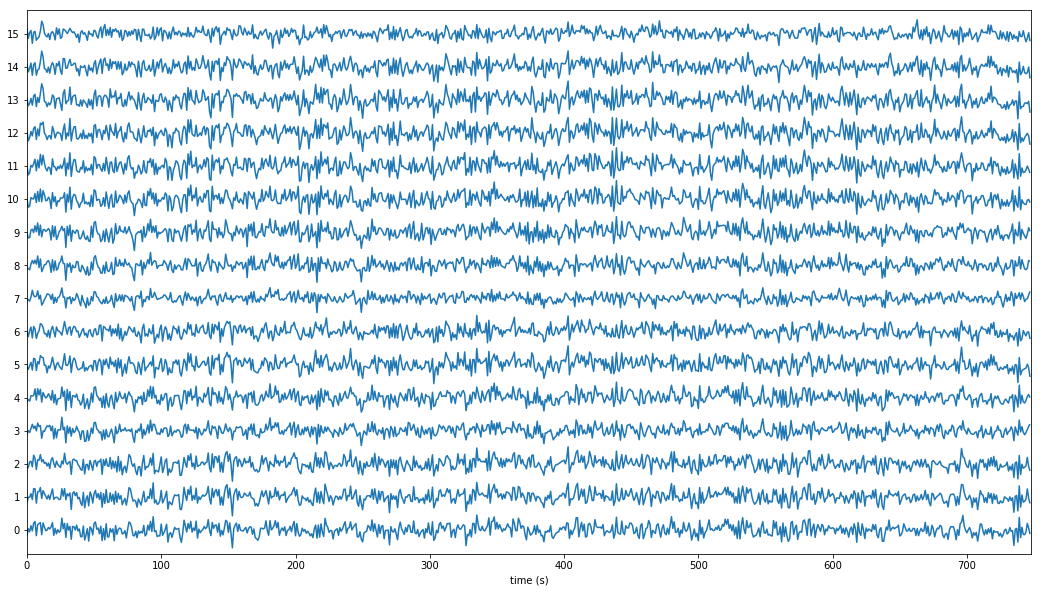

In [21]:
stacklineplot.stackplot(fwd_sample, yscale=.8)

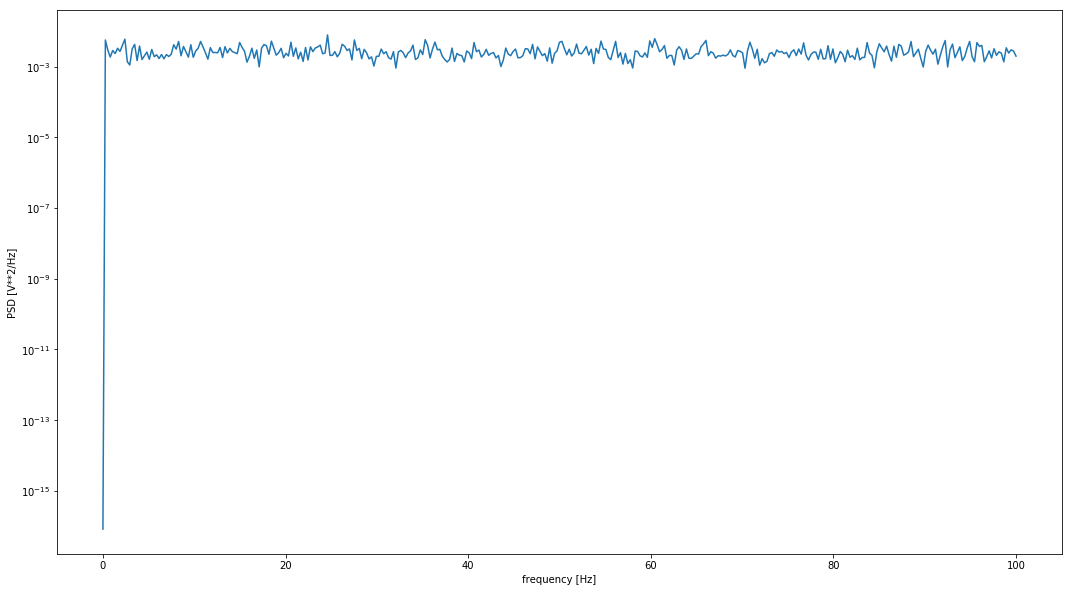

In [22]:
get_avg_dataset_psd(fwd_model_dataset)

In [187]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fftfreq, irfft, rfft

def filter_by_freq(x, lowest_freq=38, highest_freq=80, plot=False):
    if type(x) == torch.Tensor:
        x = x.numpy()
    x = x.reshape(-1)
    fs = 200
    dt = 1/fs

    W = fftfreq(x.size, d=dt)
    f_signal = rfft(x)

    cut_f_signal = f_signal.copy()
    plt.plot(cut_f_signal)
#     cut_f_signal[(np.abs(W)>highest_freq)] = 0 
#     cut_f_signal[(np.abs(W)<lowest_freq)] = 0
    print(np.min(cut_f_signal))
    cut_f_signal[W>highest_freq] = 0 
    cut_f_signal[W<lowest_freq] = 0
    plt.plot(cut_f_signal)

    cs = irfft(cut_f_signal)

    if plot:
        fig = plt.figure(figsize=(10,5))
        plt.plot(x)
        plt.plot(cs)
        
    return torch.from_numpy(cs)

import scipy
from scipy.fftpack import fft, ifft

def remove_high_freq(x):
    y = fft(x)
    mid = x.shape[1] // 2
#     y[:, x.shape[-1] // 10: x.shape[-1] // 2 + x.shape[-1] // 2] = 0
    y[:, mid - x.shape[-1] // 3: mid + x.shape[-1] // 3] = 0
    return ifft(y).real

def remove_low_freq(x):
    y = fft(x)
    y[:, :x.shape[-1] // 14] = 0
    y[:, -x.shape[-1] // 14: ] = 0
    return ifft(y).real

def filter_freq(x):
    x = x.numpy()
    x = remove_high_freq(x)
    x = remove_low_freq(x)
    return torch.from_numpy(x)

# x = filter_by_freq(dataset[0], plot=True)

In [156]:
filtered_fwd_model_dataset = ForwardModelDataset1c(64, normalize=filter_freq)

    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
Reading forward solution from /mnt/home2/dlongo/eegML/forward_model/sample_forward_model...
    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read EEG forward solution (7498 sources, 60 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    No patch info available. The standard source space normals will be employed in the rotation to the local surface coordinates....
    Changing to fixed-orientation forward solution with surface-based source orientations...
    [done]


../data/forward_model_dataloader_1c.py:64: RuntimeWarning: This filename (/mnt/home2/dlongo/eegML/forward_model/sample_forward_model) does not conform to MNE naming conventions. All forward files should end with -fwd.fif, -fwd.fif.gz, _fwd.fif or _fwd.fif.gz
  fwd = mne.read_forward_solution("/mnt/home2/dlongo/eegML/forward_model/sample_forward_model")


Projecting source estimate to sensor space...
[done]
Projecting source estimate to sensor space...
[done]
Projecting source estimate to sensor space...
[done]


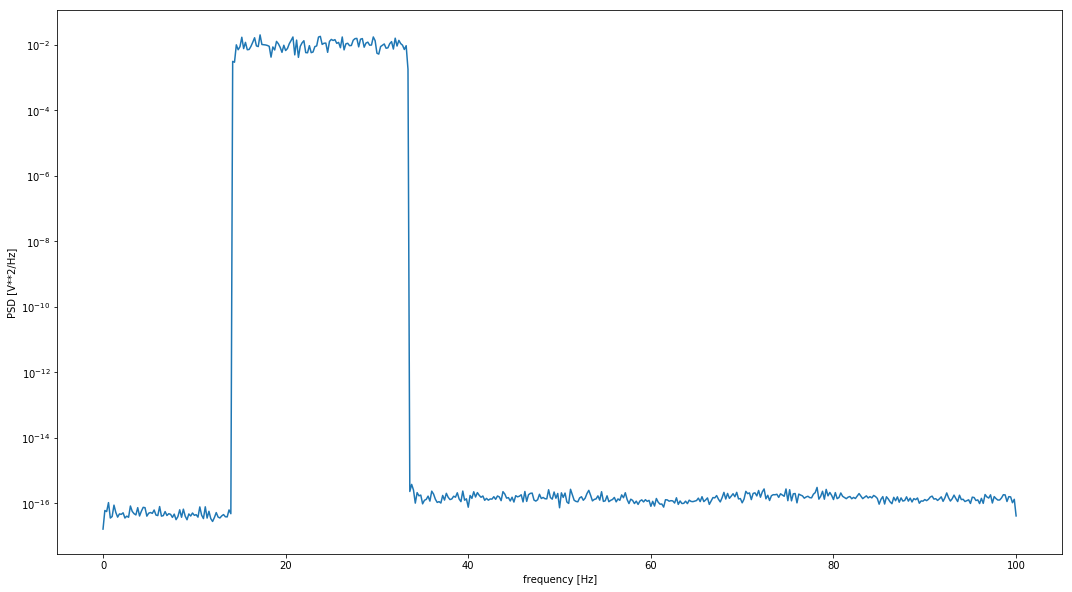

In [188]:
get_avg_dataset_psd(filtered_fwd_model_dataset)
# forward model dataloader with filter applied 

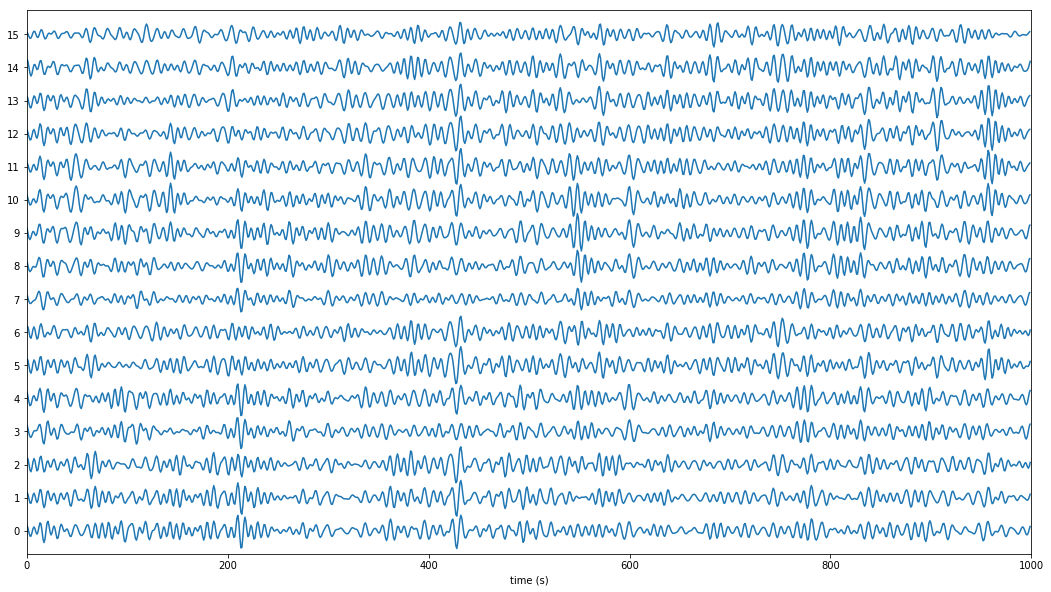

In [158]:
filter_fwd_sample = np.asarray([filtered_fwd_model_dataset[i].numpy() for i in range(16)]).squeeze()
stacklineplot.stackplot(filter_fwd_sample, yscale=.8)

### Slide 4: Combined

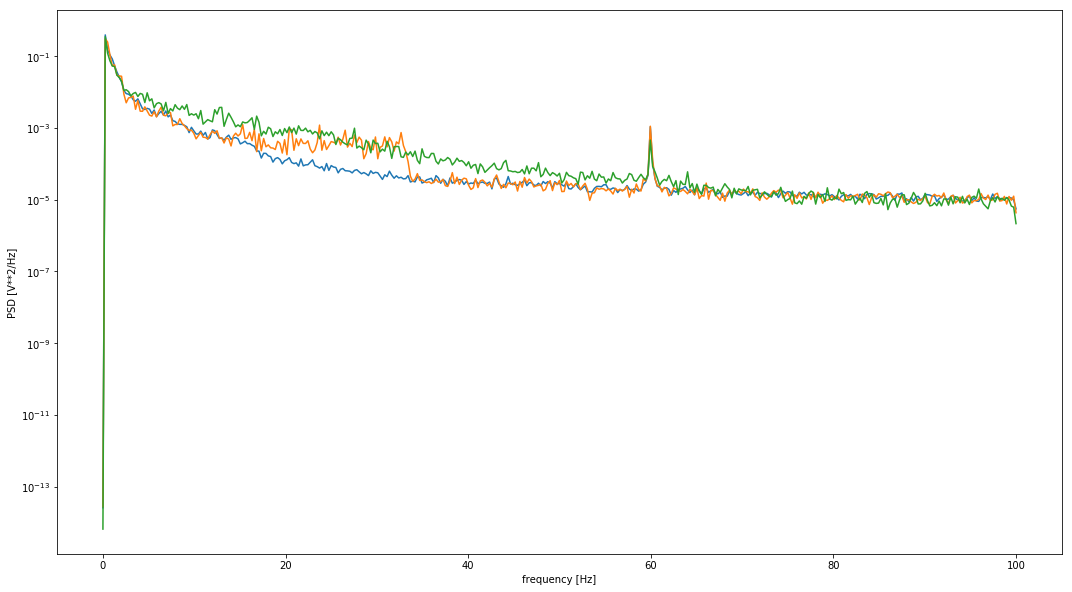

In [185]:
model = torch.load(model_filename)
model.eval()
vae_samples = model.sample(64*2)
combined_samples = []
for i in range(20):
    combined_samples.append(vae_samples[i][:784] + (filtered_fwd_model_dataset[i][0][:784].numpy()*1e-5))
    
get_avg_sampling_psd(model_filename=model_filename)
get_avg_dataset_psd(combined_samples)
get_avg_dataset_psd(dataset, plot=True)

plot of combined vae and filtered forward model

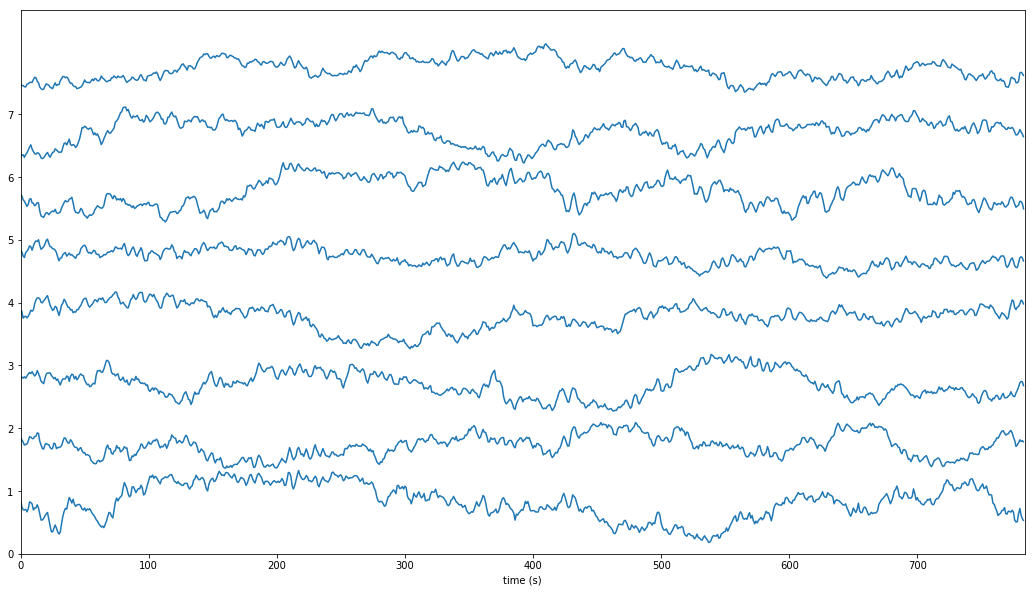

In [186]:
stacklineplot.stackplot(np.asarray(combined_samples).squeeze()[:8], yscale=.8)